In [1]:
import os
import pandas as pd
import numpy as np
from fish_helpers import *
import tqdm
import time
from scipy import sparse
import random
from ipypb import ipb
base = '/bigstore/binfo/mouse/Hippocampus/'

In [2]:
"""
Decoding dendogram
Converting to linkage
"""
import json
with open('/bigstore/binfo/mouse/Hippocampus/dend.json') as json_file:
    data = json.load(json_file)
def inspect_node(node):
    if 'leaf_attributes' in node.keys():
        attributes = node['leaf_attributes'][0]
        c = attributes['node_id']
        h = attributes['height']
        a = 'None'
        b = 'None'
        children = False
    else:
        attributes = node['node_attributes'][0]
        c = attributes['node_id']
        h = attributes['height']
        children = node['children']
        a_node = node['children'][0]
        if 'leaf_attributes' in a_node.keys():
            a = a_node['leaf_attributes'][0]['node_id']
        else:
            a = a_node['node_attributes'][0]['node_id']
        b_node = node['children'][1]
        if 'leaf_attributes' in b_node.keys():
            b = b_node['leaf_attributes'][0]['node_id']
        else:
            b = b_node['node_attributes'][0]['node_id']
    return c,h,a,b,children

C = []
H = []
A = []
B = []
node_dict = {}

node = data
c,h,a,b,children = inspect_node(node)
C.append(c)
H.append(h)
A.append(a)
B.append(b)
while len(children)>0:
    new_children = []
    for node in children:
        c,h,a,b,node_children = inspect_node(node)
        C.append(c)
        H.append(h)
        A.append(a)
        B.append(b)
        if isinstance(node_children,list):
            new_children.extend(node_children)
    children = new_children
linkage = pd.DataFrame()
linkage['C'] = C
linkage['H'] = H
linkage['A'] = A
linkage['B'] = B
"""
Convert linkage to dendrogram format
"""
sorted_linkage = linkage.sort_values('H',ascending=True)
sorted_linkage['n'] = range(len(sorted_linkage))
nA = []
for A in sorted_linkage['A']:
    if A!='None':
        nA.append(np.array(sorted_linkage[sorted_linkage['C']==A]['n'])[0])
    else:
        nA.append('None')
nB = []
for B in sorted_linkage['B']:
    if B!='None':
        nB.append(np.array(sorted_linkage[sorted_linkage['C']==B]['n'])[0])
    else:
        nB.append('None')
sorted_linkage['nA'] = nA
sorted_linkage['nB'] = nB
sorted_linkage['nC'] = list(sorted_linkage['n'])
sorted_linkage = sorted_linkage[sorted_linkage['H']>0]
sorted_linkage = sorted_linkage.sort_values('H',ascending=True)
"""
Convert to shc format
"""
linkage_shc = np.zeros((len(sorted_linkage),4))
linkage_shc[:,0] = sorted_linkage['nA']
linkage_shc[:,1] = sorted_linkage['nB']
linkage_shc[:,2] = sorted_linkage['H']
linkage_shc[:,3] = 1
"""
Convert to cell type by node matrix
"""
def find_next_node(i,df):
    temp = df[(df['A']==i)|(df['B']==i)]
    if len(temp)==1:
        return temp['C'].iloc[0]
    else:
        return False
def linkage2binary(linkage,cells):
    nnodes = len(linkage)
    ncells = len(cells)
    binary_node_matrix = np.zeros((ncells,nnodes))
    first_node = linkage['C'].iloc[0]
    for i,cell in tqdm.tqdm(enumerate(cells),total=ncells):
        node_loc = list(linkage[linkage['C']==cell].index)[0]
        binary_node_matrix[i,node_loc]=1
        new_node = find_next_node(cell,linkage)
        while isinstance(new_node,str):
            node_loc = list(linkage[linkage['C']==new_node].index)[0]
            binary_node_matrix[i,node_loc]=1
            new_node = find_next_node(new_node,linkage)
    binary_node_df = pd.DataFrame(binary_node_matrix,index=cells,columns=list(linkage['C']))
    return binary_node_df
metadata = pd.read_csv(os.path.join(base,'sample_annotations.csv'),index_col=0)
good_types = [i for i in metadata['cell_type_alias_label'].unique() if (not 'Doub' in i)&(not 'Quality' in i)&(not 'Unknown' in i)]
binary_node_df = linkage2binary(linkage,good_types)
binary_node_df = binary_node_df.T

/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (36,54) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
100%|██████████| 290/290 [00:14<00:00, 20.36it/s]


In [3]:
"""
Build cell type to cell type weight matrix
"""
n_cell_types = len(good_types)
weight_matrix = np.zeros((n_cell_types,n_cell_types))
for x,cell_type1 in tqdm.tqdm(enumerate(good_types),total=n_cell_types):
    for y,cell_type2 in enumerate(good_types):
        if x<y:
            ancester_nodes = list(binary_node_df[(binary_node_df[cell_type1]==1)&(binary_node_df[cell_type2]==1)].index)
            weight = np.min(linkage[linkage['C'].isin(ancester_nodes)]['H'])
            weight_matrix[x,y] = weight
            weight_matrix[y,x] = weight
weight_matrix_df = pd.DataFrame(weight_matrix,index=good_types,columns=good_types)

100%|██████████| 290/290 [01:55<00:00,  2.51it/s]


In [4]:
"""
Load single cell matrix and metadata
"""
# raw_counts_df = pd.read_csv(os.path.join(base,'Allen/raw_counts.csv'),index_col=0)
# metadata = pd.read_csv(os.path.join(base,'sample_annotations.csv'),index_col=0)
# """
# Checking for low quality cells and removing
# """
# good_types = [i for i in metadata['cell_type_alias_label'].unique() if (not 'Doub' in i)&(not 'Quality' in i)&(not 'Unknown' in i)]
# good_cells = list(metadata[metadata['cell_type_alias_label'].isin(good_types)].index)
# good_cells = list(set(good_cells).intersection(list(raw_counts_df.columns)))
# raw_counts_df = raw_counts_df[good_cells]
# raw_counts = np.array(raw_counts_df)
# cells = np.array(raw_counts_df.columns)
# genes = np.array(raw_counts_df.index)
# del raw_counts_df
# raw_counts_sparse = sparse.csr_matrix(raw_counts)
# sparse.save_npz(os.path.join(base,'Allen/raw_counts.npz'),raw_counts_sparse)
# pd.DataFrame(cells).to_csv(os.path.join(base,'Allen/raw_cells.csv'))
# pd.DataFrame(genes).to_csv(os.path.join(base,'Allen/raw_genes.csv'))

# """
# Loading Data from backup
# """
# raw_counts_sparse =  sparse.load_npz(os.path.join(base,'Allen/raw_counts.npz'))
# cells = np.array(pd.read_csv(os.path.join(base,'Allen/raw_cells.csv'),index_col=0)['0'])
# genes = np.array(pd.read_csv(os.path.join(base,'Allen/raw_genes.csv'),index_col=0)['0'])
# metadata = pd.read_csv(os.path.join(base,'sample_annotations.csv'),index_col=0)
# good_types = [i for i in metadata['cell_type_alias_label'].unique() if (not 'Doub' in i)&(not 'Quality' in i)&(not 'Unknown' in i)]
# raw_counts = raw_counts_sparse.A

# """
# Filter out lowly expressing genes
# """
# gene_thresh = 5
# cell_thresh = 100
# gene_filter = np.sum(1*(raw_counts>=gene_thresh),axis=1)>cell_thresh
# genes = genes[gene_filter]
# raw_counts = raw_counts[gene_filter,:]
# raw_counts_sparse = sparse.csr_matrix(raw_counts)
# sparse.save_npz(os.path.join(base,'Allen/filtered_raw_counts.npz'),raw_counts_sparse)
# pd.DataFrame(cells).to_csv(os.path.join(base,'Allen/filtered_raw_cells.csv'))
# pd.DataFrame(genes).to_csv(os.path.join(base,'Allen/filtered_raw_genes.csv'))
"""
Loading Data from backup
"""
raw_counts_sparse =  sparse.load_npz(os.path.join(base,'Allen/filtered_raw_counts.npz'))
cells =  np.array(pd.read_csv(os.path.join(base,'Allen/filtered_raw_cells.csv'),index_col=0)['0'])
genes = np.array(pd.read_csv(os.path.join(base,'Allen/filtered_raw_genes.csv'),index_col=0)['0'])
metadata = pd.read_csv(os.path.join(base,'sample_annotations.csv'),index_col=0)
good_types = [i for i in metadata['cell_type_alias_label'].unique() if (not 'Doub' in i)&(not 'Quality' in i)&(not 'Unknown' in i)]
raw_counts = raw_counts_sparse.A
normalized_raw_counts = np.divide(raw_counts,np.sum(raw_counts,axis=0))*10**6
del raw_counts

/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (36,54) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
"""
Generating Cell Type Lookup Table
"""
cell_type_loc = {}
labels = np.array(metadata['cell_type_alias_label'].loc[list(cells)])
for cell_type in np.unique(labels):
    cell_type_loc[cell_type] = np.where(labels==cell_type)[0]

In [6]:
"""
Normalize by cell size
"""
normalized_raw_counts = np.divide(raw_counts,np.sum(raw_counts,axis=0))*10**6
del raw_counts

In [7]:
"""
Calculate median and variance for each gene for each cell type
"""
indexes = list(range(len(cells)))
cell_types = cell_type_loc.keys()
n_cell_types = len(cell_types)
ngenes = len(genes)
normalized_cell_type_medians= np.zeros((n_cell_types,ngenes))
normalized_cell_type_variance = np.zeros((n_cell_types,ngenes))
for i,cell_type in enumerate(cell_types):
    loc = cell_type_loc[cell_type]
    if len(loc)>0: # if there are no cells for that node keep as 0?
        cel_type_counts = normalized_raw_counts[:,loc]
        normalized_cell_type_medians[i,:] = np.median(cel_type_counts,axis=1)
        normalized_cell_type_variance[i,:] = np.std(cel_type_counts,axis=1)
"""
cell_type loop
elementwise
matrix subtraction of medians
matrix addition of variances
Use Nodes heights as weights
Calculate seperability for genes independantly
"""
weights = weight_matrix
normalized_seperability_matrix = np.zeros_like(normalized_cell_type_medians)
for i in range(n_cell_types):
    median = normalized_cell_type_medians[i,:]
    variance = normalized_cell_type_variance[i,:]
    delta_medians = np.abs(np.subtract(normalized_cell_type_medians,median[None,:]))
    sigma_variances = np.add(normalized_cell_type_variance,variance[None,:])
    seperability = np.divide(delta_medians,sigma_variances)
    seperability[seperability==np.inf]=0
    weighted_seperability = np.multiply(seperability,weights[i,:][:,None])
    weighted_seperability[weighted_seperability==np.inf]=0
    normalized_seperability_matrix[i,:] = np.nansum(weighted_seperability,axis=0)
normalized_total_seperation = np.sum(normalized_seperability_matrix,axis=0)
"""
Calculate median and variance for each gene for each cell type
"""
indexes = list(range(len(cells)))
cell_types = cell_type_loc.keys()
n_cell_types = len(cell_types)
ngenes = len(genes)
normalized_cell_type_medians_permuted = np.zeros((n_cell_types,ngenes))
normalized_cell_type_variance_permuted = np.zeros((n_cell_types,ngenes))
for i,cell_type in enumerate(cell_types):
    loc = cell_type_loc[cell_type]
    if len(loc)>0: # if there are no cells for that node keep as 0?
        loc = np.array(random.sample(indexes,len(loc)))
        cel_type_counts_permuted = normalized_raw_counts[:,loc]
        normalized_cell_type_medians_permuted[i,:] = np.median(cel_type_counts_permuted,axis=1)
        normalized_cell_type_variance_permuted[i,:] = np.std(cel_type_counts_permuted,axis=1)
"""
cell_type loop
elementwise
matrix subtraction of medians
matrix addition of variances
Use Nodes heights as weights
Calculate seperability for genes independantly
"""
weights = weight_matrix
normalized_seperability_matrix_permuted = np.zeros_like(normalized_cell_type_medians)
for i in range(n_cell_types):
    median = normalized_cell_type_medians_permuted[i,:]
    variance = normalized_cell_type_variance_permuted[i,:]
    delta_medians = np.abs(np.subtract(normalized_cell_type_medians_permuted,median[None,:]))
    sigma_variances = np.add(normalized_cell_type_variance_permuted,variance[None,:])
    seperability = np.divide(delta_medians,sigma_variances)
    seperability[seperability==np.inf]=0
    weighted_seperability = np.multiply(seperability,weights[i,:][:,None])
    weighted_seperability[weighted_seperability==np.inf]=0
    normalized_seperability_matrix_permuted[i,:] = np.nansum(weighted_seperability,axis=0)
normalized_total_seperation_permuted = np.sum(normalized_seperability_matrix_permuted,axis=0)


/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in true_divide


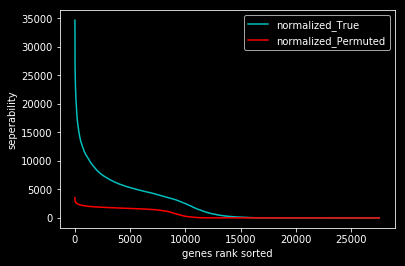

In [8]:
normalized_sorted_seperability = pd.DataFrame(normalized_total_seperation,index=genes,columns=['seperability']).sort_values('seperability',ascending=False)
normalized_sorted_seperability_permuted = pd.DataFrame(normalized_total_seperation_permuted,index=genes,columns=['seperability']).sort_values('seperability',ascending=False)
plt.style.use(['dark_background'])
plt.plot(np.array(range(len(normalized_sorted_seperability))),normalized_sorted_seperability,c='c',label='normalized_True')
plt.plot(np.array(range(len(normalized_sorted_seperability_permuted))),normalized_sorted_seperability_permuted,c='r',label='normalized_Permuted')
plt.xlabel('genes rank sorted')
plt.ylabel('seperability')
plt.legend()
plt.show()


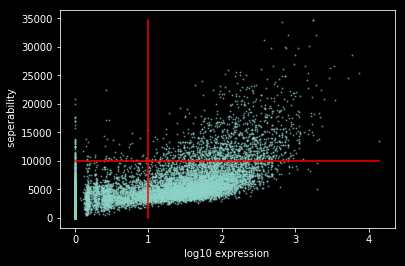

In [9]:
normalized_median_expression = pd.DataFrame(np.median(normalized_raw_counts,axis=1),index=genes)
normalized_sorted_seperability['expression'] = normalized_median_expression
plt.style.use(['dark_background'])
plt.scatter(np.log10(normalized_sorted_seperability['expression']+1),normalized_sorted_seperability['seperability'],s=1,alpha=0.5)
plt.plot([1,1],[0,np.max(normalized_sorted_seperability['seperability'])],c='r')
plt.plot([0,np.max(np.log10(normalized_sorted_seperability['expression']+1))],[10000,10000],c='r')
plt.xlabel('log10 expression')
plt.ylabel(' seperability')
plt.show()

In [ ]:
"""
Save seperability filtered counts
"""
filtered_mask = np.isin(genes,np.array(filtered_genes.index))
filtered_genes = genes[filtered_mask]
filtered_counts = normalized_raw_counts[filtered_mask,:]
filtered_counts_sparse = sparse.csr_matrix(filtered_counts)

sparse.save_npz(os.path.join(base,'Allen/seperability_filtered_counts.npz'),filtered_counts_sparse)
pd.DataFrame(cells).to_csv(os.path.join(base,'Allen/seperability_filtered_cells.csv'))
pd.DataFrame(filtered_genes).to_csv(os.path.join(base,'Allen/seperability_filtered_genes.csv'))

In [ ]:
"""
Maybe Divide by the weights not multiply
"""

In [10]:
"""
cell_type loop
elementwise
matrix subtraction of medians
matrix addition of variances
Use Nodes heights as weights
Calculate seperability for genes independantly
"""
weights = weight_matrix
normalized_seperability_matrix_divided = np.zeros_like(normalized_cell_type_medians)
for i in range(n_cell_types):
    median = normalized_cell_type_medians[i,:]
    variance = normalized_cell_type_variance[i,:]
    delta_medians = np.abs(np.subtract(normalized_cell_type_medians,median[None,:]))
    sigma_variances = np.add(normalized_cell_type_variance,variance[None,:])
    seperability = np.divide(delta_medians,sigma_variances)
    seperability[seperability==np.inf]=0
    weighted_seperability = np.divide(seperability,weights[i,:][:,None])
    weighted_seperability[weighted_seperability==np.inf]=0
    normalized_seperability_matrix[i,:] = np.nansum(weighted_seperability,axis=0)
normalized_total_seperation_divided = np.sum(normalized_seperability_matrix,axis=0)
"""
cell_type loop
elementwise
matrix subtraction of medians
matrix addition of variances
Use Nodes heights as weights
Calculate seperability for genes independantly
"""
weights = weight_matrix
normalized_seperability_matrix_permuted_divided = np.zeros_like(normalized_cell_type_medians)
for i in range(n_cell_types):
    median = normalized_cell_type_medians_permuted[i,:]
    variance = normalized_cell_type_variance_permuted[i,:]
    delta_medians = np.abs(np.subtract(normalized_cell_type_medians_permuted,median[None,:]))
    sigma_variances = np.add(normalized_cell_type_variance_permuted,variance[None,:])
    seperability = np.divide(delta_medians,sigma_variances)
    seperability[seperability==np.inf]=0
    weighted_seperability = np.divide(seperability,weights[i,:][:,None])
    weighted_seperability[weighted_seperability==np.inf]=0
    normalized_seperability_matrix_permuted[i,:] = np.nansum(weighted_seperability,axis=0)
normalized_total_seperation_permuted_divided = np.sum(normalized_seperability_matrix_permuted,axis=0)

/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


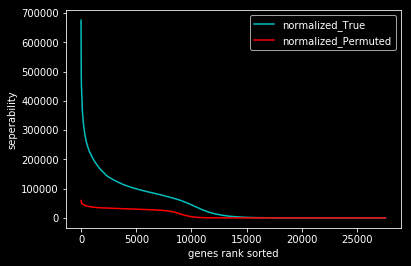

In [11]:
normalized_sorted_seperability_divided = pd.DataFrame(normalized_total_seperation_divided,index=genes,columns=['seperability']).sort_values('seperability',ascending=False)
normalized_sorted_seperability_permuted_divided = pd.DataFrame(normalized_total_seperation_permuted_divided,index=genes,columns=['seperability']).sort_values('seperability',ascending=False)
plt.style.use(['dark_background'])
plt.plot(np.array(range(len(normalized_sorted_seperability_divided))),normalized_sorted_seperability_divided,c='c',label='normalized_True')
plt.plot(np.array(range(len(normalized_sorted_seperability_permuted_divided))),normalized_sorted_seperability_permuted_divided,c='r',label='normalized_Permuted')
plt.xlabel('genes rank sorted')
plt.ylabel('seperability')
plt.legend()
plt.show()

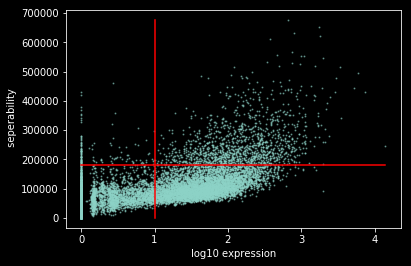

In [19]:
normalized_median_expression= pd.DataFrame(np.median(normalized_raw_counts,axis=1),index=genes)
normalized_sorted_seperability_divided['expression'] = normalized_median_expression
plt.style.use(['dark_background'])
plt.scatter(np.log10(normalized_sorted_seperability_divided['expression']+1),normalized_sorted_seperability_divided['seperability'],s=1,alpha=0.5)
plt.plot([1,1],[0,np.max(normalized_sorted_seperability_divided['seperability'])],c='r')
plt.plot([0,np.max(np.log10(normalized_sorted_seperability_divided['expression']+1))],[180000,180000],c='r')
plt.xlabel('log10 expression')
plt.ylabel(' seperability')
plt.show()

In [18]:
"""
Filter Genes
"""
filtered_genes = normalized_sorted_seperability[(normalized_sorted_seperability.seperability>10000)&(normalized_sorted_seperability['expression']>10)]
filtered_genes_divided = normalized_sorted_seperability_divided[(normalized_sorted_seperability_divided.seperability>180000)&(normalized_sorted_seperability_divided['expression']>10)]
print(len(filtered_genes))
print(len(filtered_genes_divided))

1220
1327


In [20]:
len(list(set(filtered_genes).intersection(filtered_genes_divided)))

2

In [22]:
"""
Save seperability filtered counts
"""
filtered_mask_divided = np.isin(genes,np.array(filtered_genes_divided.index))
filtered_genes_divided = genes[filtered_mask_divided]
filtered_counts_divided = normalized_raw_counts[filtered_mask_divided,:]
filtered_counts_sparse_divided = sparse.csr_matrix(filtered_counts_divided)

sparse.save_npz(os.path.join(base,'Allen/seperability_filtered_counts_divided.npz'),filtered_counts_sparse_divided)
pd.DataFrame(cells).to_csv(os.path.join(base,'Allen/seperability_filtered_cells_divided.csv'))
pd.DataFrame(filtered_genes_divided).to_csv(os.path.join(base,'Allen/seperability_filtered_genes_divided.csv'))

In [ ]:
"""
Using All of the nodes
"""

In [7]:
nodes = list(linkage['C'])
node_df = linkage2binary(linkage,nodes).T

100%|██████████| 579/579 [00:27<00:00, 21.29it/s]


In [11]:
"""
Create node by node weight
if a node is part of another node then 0 weight
"""
nodes = list(linkage['C'])
n_nodes = len(nodes)
node_weight_matrix = np.zeros((n_nodes,n_nodes))
node_weight_matrix[:,:] = np.nan
for x,node1 in tqdm.tqdm(enumerate(nodes),total=n_nodes):
    for y,node2 in enumerate(nodes):
        if x<y:
            ancester_nodes = list(node_df[(node_df[node1]==1)&(node_df[node2]==1)].index)
            ancester_node_df = linkage[linkage['C'].isin(ancester_nodes)].sort_values('H',ascending=True)
            common_ancestor = ancester_node_df['C'].iloc[0]
            if not np.isin(common_ancestor,[node1,node2]):
                weight = ancester_node_df['H'].iloc[0]
                node_weight_matrix[x,y] = weight
                node_weight_matrix[y,x] = weight
node_weight_matrix_df = pd.DataFrame(node_weight_matrix,index=nodes,columns=nodes)


100%|██████████| 579/579 [10:04<00:00,  1.04s/it]


In [19]:
node_weight_matrix_df

,n1,n2,n281,n3,n274,n283,n282,n4,CR,n277,...,L2/3 IT Otof_4,n151,L4/5 IT_9,L4/5 IT_10,L4/5 IT_13,L4/5 IT_14,L5 IT_8,L5 IT_9,L2/3 IT Otof_5,L2/3 IT Otof_6
n1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n2,NaN,NaN,0.8416,NaN,NaN,0.8416,0.8416,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n281,NaN,0.8416,NaN,0.8416,0.8416,NaN,NaN,0.8416,0.8416,0.8416,...,0.8416,0.8416,0.8416,0.8416,0.8416,0.8416,0.8416,0.8416,0.8416,0.8416
n3,NaN,NaN,0.8416,NaN,0.6271,0.8416,0.8416,NaN,NaN,0.6271,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n274,NaN,NaN,0.8416,0.6271,NaN,0.8416,0.8416,0.6271,0.6271,NaN,...,0.6271,0.6271,0.6271,0.6271,0.6271,0.6271,0.6271,0.6271,0.6271,0.6271
n283,NaN,0.8416,NaN,0.8416,0.8416,NaN,0.7175,0.8416,0.8416,0.8416,...,0.8416,0.8416,0.8416,0.8416,0.8416,0.8416,0.8416,0.8416,0.8416,0.8416
n282,NaN,0.8416,NaN,0.8416,0.8416,0.7175,NaN,0.8416,0.8416,0.8416,...,0.8416,0.8416,0.8416,0.8416,0.8416,0.8416,0.8416,0.8416,0.8416,0.8416
n4,NaN,NaN,0.8416,NaN,0.6271,0.8416,0.8416,NaN,0.3650,0.6271,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CR,NaN,NaN,0.8416,NaN,0.6271,0.8416,0.8416,0.3650,NaN,0.6271,...,0.3650,0.3650,0.3650,0.3650,0.3650,0.3650,0.3650,0.3650,0.3650,0.3650
n277,NaN,NaN,0.8416,0.6271,NaN,0.8416,0.8416,0.6271,0.6271,NaN,...,0.6271,0.6271,0.6271,0.6271,0.6271,0.6271,0.6271,0.6271,0.6271,0.6271


In [12]:
"""
Generating Node Lookup Table
"""
cts = np.array(binary_node_df.columns)
node_loc = {}
labels = np.array(metadata['cell_type_alias_label'].loc[list(cells)])
for node in nodes:
    loc = np.array([])
    for ct in cts[np.array(binary_node_df.loc[node]==1)]:
        loc = np.concatenate((loc,np.where(labels==cell_type)[0]))
    node_loc[node] = loc.astype(int)

In [ ]:
"""
Below is too slow
"""

In [26]:
"""
Calculate median and variance for each gene for each node
"""
n_nodes = len(nodes)
indexes = list(range(len(nodes)))
ngenes = len(genes)
normalized_nodes_medians= np.zeros((n_nodes,ngenes))
normalized_nodes_variance = np.zeros((n_nodes,ngenes))
normalized_nodes_medians[:,:] = np.nan
normalized_nodes_variance[:,:] = np.nan
for i,node in ipb(enumerate(nodes),n_nodes):
    if node=='n1':
        continue
    loc = node_loc[node]
    if len(loc)>0:
        node_counts = normalized_raw_counts[:,loc]
        normalized_nodes_medians[i,:] = np.median(node_counts,axis=1)
        normalized_nodes_variance[i,:] = np.std(node_counts,axis=1)
print('Medians and Variance Calculated')
"""
cell_type loop
elementwise
matrix subtraction of medians
matrix addition of variances
Use Nodes heights as weights
Calculate seperability for genes independantly
"""
weights = node_weight_matrix
normalized_seperability_matrix = np.zeros_like(normalized_nodes_medians)
for i,node in ipb(enumerate(nodes),n_nodes):
    if node=='n1':
        continue
    median = normalized_nodes_medians[i,:]
    variance = normalized_nodes_variance[i,:]
    delta_medians = np.abs(np.subtract(normalized_nodes_medians,median[None,:]))
    sigma_variances = np.add(normalized_nodes_variance,variance[None,:])
    seperability = np.divide(delta_medians,sigma_variances)
    seperability[seperability==np.inf]=0
    weighted_seperability = np.multiply(seperability,weights[i,:][:,None])
    weighted_seperability[weighted_seperability==np.inf]=0
    normalized_seperability_matrix[i,:] = np.nansum(weighted_seperability,axis=0)
normalized_node_seperation = np.sum(normalized_seperability_matrix,axis=0)
print('normalized_node_seperation Calculated')

 [############################################################] 0/579 [0<0, 0.00s/it]

KeyboardInterrupt: 

In [ ]:
"""
Calculate median and variance for each gene for each cell type
"""
n_nodes = len(nodes)
indexes = list(range(len(nodes)))
ngenes = len(genes)
normalized_nodes_medians_permuted = np.zeros((n_nodes,ngenes))
normalized_nodes_variance_permuted = np.zeros((n_nodes,ngenes))
normalized_nodes_medians_permuted[:,:] = np.nan
normalized_nodes_variance_permuted[:,:] = np.nan
for i,node in ipb(enumerate(nodes),n_nodes):
    if node=='n1':
        continue
    loc = node_loc[node]
    if len(loc)>0: # if there are no cells for that node keep as 0?
        loc = np.array(random.sample(indexes,len(loc)))
        node_counts = normalized_raw_counts[:,loc]
        normalized_nodes_medians_permuted[i,:] = np.median(node_counts,axis=1)
        normalized_nodes_variance_permuted[i,:] = np.std(node_counts,axis=1)
print('Permuted Medians and Variance Calculated')
"""
cell_type loop
elementwise
matrix subtraction of medians
matrix addition of variances
Use Nodes heights as weights
Calculate seperability for genes independantly
"""
weights = node_weight_matrix
normalized_seperability_matrix_permuted = np.zeros_like(normalized_nodes_medians_permuted)
for i,node in ipb(enumerate(nodes),n_nodes):
    if node=='n1':
        continue
    median = normalized_nodes_medians_permuted[i,:]
    variance = normalized_nodes_variance_permuted[i,:]
    delta_medians = np.abs(np.subtract(normalized_nodes_medians_permuted,median[None,:]))
    sigma_variances = np.add(normalized_nodes_variance_permuted,variance[None,:])
    seperability = np.divide(delta_medians,sigma_variances)
    seperability[seperability==np.inf]=0
    weighted_seperability = np.multiply(seperability,weights[i,:][:,None])
    weighted_seperability[weighted_seperability==np.inf]=0
    normalized_seperability_matrix_permuted[i,:] = np.nansum(weighted_seperability,axis=0)
normalized_node_seperation_permuted = np.nansum(normalized_seperability_matrix_permuted,axis=0)
print('normalized_node_seperation_permuted Calculated')

In [ ]:
normalized_node_seperation_sorted= pd.DataFrame(normalized_node_seperation,index=genes,columns=['seperability']).sort_values('seperability',ascending=False)
normalized_node_seperation_permuted_sorted = pd.DataFrame(normalized_node_seperation_permuted_divided,index=genes,columns=['seperability']).sort_values('seperability',ascending=False)
plt.style.use(['dark_background'])
plt.plot(np.array(range(len(normalized_node_seperation_sorted))),normalized_node_seperation_sorted,c='c',label='normalized_True')
plt.plot(np.array(range(len(normalized_node_seperation_permuted_sorted))),normalized_node_seperation_permuted_sorted,c='r',label='normalized_Permuted')
plt.xlabel('genes rank sorted')
plt.ylabel('seperability')
plt.legend()
plt.show()

In [ ]:
normalized_median_expression= pd.DataFrame(np.median(normalized_raw_counts,axis=1),index=genes)
normalized_node_seperation_sorted['expression'] = normalized_median_expression
plt.style.use(['dark_background'])
plt.scatter(np.log10(normalized_node_seperation_sorted['expression']+1),normalized_node_seperation_sorted['seperability'],s=1,alpha=0.5)
plt.plot([1,1],[0,np.max(normalized_node_seperation_sorted['seperability'])],c='r')
plt.plot([0,np.max(np.log10(normalized_node_seperation_sorted['expression']+1))],[180000,180000],c='r')
plt.xlabel('log10 expression')
plt.ylabel(' seperability')
plt.show()